# How To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects

- Create subject-specific pre-pregnancy atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific pre-pregnancy atlas $X_{i, \text{pre-pregnancy}}$.

- Create global pre-pregnancy atlas:
  - Compute global pre-pregnancy atlas from subject-specific pre-pregnancy atlases: $X^{\text{pre-pregnancy}} = \text{mean}_i ~~X^{\text{pre-pregnancy}}_{i}$.

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation from pre-pregnancy atlas to each pregnancy mesh, using control points of global atlas: $\text{deformation}_{it} = X^{\text{pre-pregnancy}}_{i} \rightarrow X^{\text{pregnancy}}_{it}$ as momenta at control points
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [1]:
import pyvista as pv
from pathlib import Path

import numpy as np

from in_out.array_readers_and_writers import read_3D_array

import polpo.lddmm as lddmm
import polpo.lddmm.strings as lddmm_strings

from polpo.lddmm.geometry import transport, shoot

from polpo.preprocessing.load.pregnancy import (
    DenseMaternalMeshLoader,
    DenseMaternalCsvDataLoader,
)
from polpo.preprocessing.mesh.io import PvReader, PvWriter
from polpo.preprocessing import Map, PartiallyInitializedStep
from polpo.preprocessing.mesh.registration import PvAlign

SUBJECT_IDS = ["01", "1001", "1004"]

RESULTS_DIR = Path("results")
ATLAS_DIR = RESULTS_DIR / "atlases"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"
TRANSPORTS_DIR = RESULTS_DIR / "transports"

GLOBAL_ATLAS_DIR = ATLAS_DIR / "global_atlas"
SUBJECT_ATLAS_DIR = {
    "01": ATLAS_DIR / "subject01_atlas",
    "1001": ATLAS_DIR / "subject1001_atlas",
    "1004": ATLAS_DIR / "subject1004_atlas",
}

SUBJECT_REGISTRATION_DIR = {
    "01": REGISTRATIONS_DIR / "subject01_registrations",
    "1001": REGISTRATIONS_DIR / "subject1001_registrations",
    "1004": REGISTRATIONS_DIR / "subject1004_registrations",
}

TRANSPORTS_DIR.mkdir(parents=True, exist_ok=True)
SUBJECT_TRANSPORTS_DIR = {  
    "01": TRANSPORTS_DIR / "01",
    "1001": TRANSPORTS_DIR / "1001",
    "1004": TRANSPORTS_DIR / "1004",
}

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
for dir in [ATLAS_DIR, REGISTRATIONS_DIR, GLOBAL_ATLAS_DIR, TRANSPORTS_DIR]:
    dir.mkdir(parents=True, exist_ok=True)
for subject_id in SUBJECT_IDS:
    SUBJECT_ATLAS_DIR[subject_id].mkdir(parents=True, exist_ok=True) 
    SUBJECT_REGISTRATION_DIR[subject_id].mkdir(parents=True, exist_ok=True)
    SUBJECT_TRANSPORTS_DIR[subject_id].mkdir(parents=True, exist_ok=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# load meshes of all three subjects for left hipp structure using DenseMaternalMeshLoader
raw_meshes = {}
csvs = {}
n_meshes = {}

for subject_id in SUBJECT_IDS:
    pipe = DenseMaternalMeshLoader(
        data_dir="/home/data/maternal",
        subject_id=subject_id,
        as_dict=False,
        left=True,
        struct="Hipp",
    ) + Map(PvReader())

    raw_meshes[subject_id] = pipe()

    n_meshes[subject_id] = len(raw_meshes[subject_id])
    print(f"Number of meshes for subject {subject_id}: {n_meshes[subject_id]}")

    # TODO: FIX this inconsistent imports between subject 01 and other subjects
    if subject_id == "01":
        csvs[subject_id] = DenseMaternalCsvDataLoader(
            subject_id=subject_id)() 
    else:
        csvs[subject_id] = DenseMaternalCsvDataLoader(
            data_dir="/home/data/maternal",
            subject_id=subject_id+"B")()

INFO: Data has already been downloaded... using cached file ('/home/nmiolane/.herbrain/data/maternal/maternal_brain_project_pilot/rawdata/28Baby_Hormones.csv').


Number of meshes for subject 01: 27
Number of meshes for subject 1001: 13
Number of meshes for subject 1004: 21


In [13]:
for subject_id in SUBJECT_IDS:
    display(csvs[subject_id])

,estro,prog,lh,gestWeek,stage,EndoStatus,trimester
sessionID,,,,,,,
1,NaN,NaN,NaN,-3.0,pre,pilot1,pre
2,3.42,0.840,NaN,-0.5,pre,pilot2,pre
3,386.00,NaN,NaN,1.0,pre,IVF,pre
4,1238.00,NaN,NaN,1.5,pre,IVF,pre
5,1350.00,2.940,NaN,2.0,pre,IVF,first
6,241.00,8.760,NaN,3.0,preg,Pregnant,first
7,NaN,NaN,NaN,9.0,preg,Pregnant,first
8,NaN,NaN,NaN,12.0,preg,Pregnant,first
9,NaN,NaN,NaN,14.0,preg,Pregnant,second


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-18.0,pre,pre,4/1/2023
base2,-13.0,pre,pre,5/6/2023
gest1,8.0,preg,first,9/30/2023
gest2,13.0,preg,first,11/4/2023
gest3,17.0,preg,second,12/2/2023
gest4,22.0,preg,second,1/6/2024
gest5,26.0,preg,second,2/3/2024
gest6,30.0,preg,third,3/2/2024
gest7,35.0,preg,third,4/6/2024


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-2.5,pre,pre,8/22/2023
base2,2.0,preg,first,9/21/2023
gest1,5.0,preg,first,10/11/2023
gest2,7.0,preg,first,10/26/2023
gest3,8.5,preg,first,11/7/2023
gest4,10.5,preg,first,11/20/2023
gest5,12.5,preg,first,12/4/2023
gest6,14.5,preg,second,12/18/2023
gest7,16.5,preg,second,1/3/2024


2025-08-28 16:43:38.787 ( 183.802s) [    7FE419F0A440]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


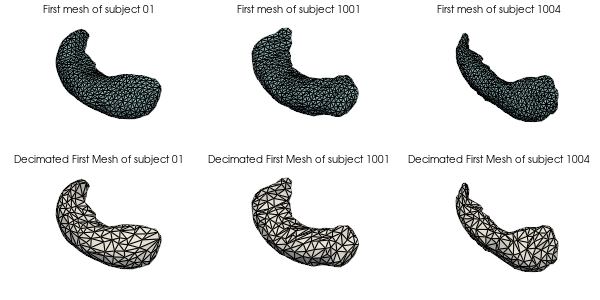

In [9]:
# Rigid alignment of all meshes to the first mesh of subject 01

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

all_raw_meshes = prep_pipe([mesh for subject_id in SUBJECT_IDS for mesh in raw_meshes[subject_id]])

rigidly_aligned_meshes = {
    "01": all_raw_meshes[:n_meshes["01"]],
    "1001": all_raw_meshes[n_meshes["01"]:n_meshes["01"] + n_meshes["1001"]],
    "1004": all_raw_meshes[n_meshes["01"] + n_meshes["1001"]:],
}

meshes = {
    "01": [],
    "1001": [],
    "1004": [],
}
# Coarsen all meshes to reduce number of vertices
target_reduction = 0.6  # Reduce number of vertices by 50%

for subject_id in SUBJECT_IDS:
    for mesh in rigidly_aligned_meshes[subject_id]:        
        meshes[subject_id].append(mesh.decimate(target_reduction=target_reduction))
    meshes[subject_id] = np.array(meshes[subject_id])

pl = pv.Plotter(shape=(2,3), border=False, window_size=[600, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0,i)
    pl.add_mesh(rigidly_aligned_meshes[subject_id][0], show_edges=True)
    pl.add_text(f"First mesh of subject {subject_id}", position='upper_edge', font_size=4)

    pl.subplot(1,i)
    pl.add_mesh(meshes[subject_id][0], show_edges=True, color='white')
    pl.add_text(f"Decimated First Mesh of subject {subject_id}", position='upper_edge', font_size=4)

pl.show()


In [10]:
registration_kwargs = dict(
    kernel_width=10,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    # attachment_kernel_width=2.0,
    tol=1e-10,
    # filter_cp=True,
    # threshold=0.75,
)

In [14]:
# Compute subject specific deterministic atlas by averaging pre-pregnancy meshes
templates = {
    "01": None,
    "1001": None,
    "1004": None,  # can't be hardcoded, even if there is only one pre- mesh in 1004, bcs of filenames
    "global": None,
}

for subject_id in SUBJECT_IDS:
    subject_csv = csvs[subject_id]
    subject_meshes = meshes[subject_id]
    assert len(subject_meshes) == len(subject_csv)
    pre_indices = subject_csv.reset_index().index[subject_csv["trimester"] == "pre"]
    # Select corresponding pre-pregnancy meshes
    pre_meshes = [subject_meshes[i] for i in pre_indices]
    print(f"Subject {subject_id}: Found {len(pre_meshes)} pre-pregnancy meshes")

    meshes_writer = Map(PvWriter(dirname=SUBJECT_ATLAS_DIR[subject_id], ext="vtk"))

    mesh_filenames = meshes_writer(
        [(f"premesh{subject_id}_{index}", mesh) for index, mesh in enumerate(pre_meshes)]
    )
    dataset = [{"shape": filename} for filename in mesh_filenames]

    lddmm.estimate_deterministic_atlas(
        source=dataset[0]["shape"],
        targets=dataset,
        subject_id="structure",  # WHY?
        output_dir=SUBJECT_ATLAS_DIR[subject_id],
        initial_step_size=1e-1,
        **registration_kwargs,
    )
    templates[subject_id] = PvReader()(SUBJECT_ATLAS_DIR[subject_id] / lddmm_strings.template_str)

# compute global prepregnancy control deterministic atlas
meshes_writer = Map(PvWriter(dirname=GLOBAL_ATLAS_DIR, ext="vtk"))

mesh_filenames = meshes_writer(
    [(f"template_{index}", mesh) for index, mesh in enumerate([templates["1001"], templates["1004"]])]
)
dataset = [{"shape": filename} for filename in mesh_filenames]

lddmm.estimate_deterministic_atlas(
    source=dataset[0]["shape"],
    targets=dataset,
    subject_id="structure",
    output_dir=GLOBAL_ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)
templates["global"] = PvReader()(GLOBAL_ATLAS_DIR / lddmm_strings.template_str)

Subject 01: Found 4 pre-pregnancy meshes
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlases/subject01_atlas/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_method_type': 'S

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


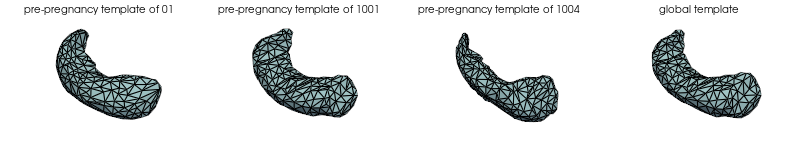

In [16]:
pl = pv.Plotter(shape=(1,4), border=False, window_size=[800, 150])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates[subject_id], show_edges=True)
    pl.add_text(f"pre-pregnancy template of {subject_id}", position='upper_edge', font_size=4)

pl.subplot(0,3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position='upper_edge', font_size=4)

pl.show()

In [ ]:
# # compute the deformation between the pre-pregnancy template of 1001 and each mesh of 1001, using the control points of the global atlas
# # then, transport the time deformation along the subject-to-patient deformation

# # This take 4 minutes: NOTE: This steep is not needed bcs it'll be done within the folow up parallel transport step
# for subject_id in ["1001", "1004"]:
#     for i_mesh, mesh in enumerate(meshes[subject_id]):
        
#         mesh_registration_dir = SUBJECT_REGISTRATION_DIR[subject_id] / f"mesh_{i_mesh}"
#         mesh_registration_dir.mkdir(parents=True, exist_ok=True)
        
#         meshes_writer = Map(PvWriter(dirname=mesh_registration_dir, ext="vtk"))

#         mesh_filenames = meshes_writer(
#             [(f"mesh_{index}", mesh) for index, mesh in enumerate([templates[subject_id], mesh])]
#         )

#         fixed_control_points_registration_kwargs = {
#             **registration_kwargs,
#             "freeze_control_points": True,
#             # get the control points of the global atlas (mapping to each subject-specific pre-pregnancy atlasees)
#             "initial_control_points": GLOBAL_ATLAS_DIR / lddmm_strings.cp_str
#         }

#         lddmm.registration.estimate_registration(
#             source=mesh_filenames[0],  #template 
#             target=mesh_filenames[1],  #mesh
#             output_dir=mesh_registration_dir,
#             **fixed_control_points_registration_kwargs,
#         )

In [25]:
# parallel transport the momenta (?) of each subject from its subject-specific template to the global template


n_rungs = 11
transport_args = {"kernel_type": "torch", "kernel_width": 4, "n_rungs":11}
shoot_args = {
    'use_rk2_for_flow': True, 'kernel_width': registration_kwargs["kernel_width"],
    'number_of_time_steps': n_rungs + 1, 'write_params': False}

#NOTE : according to deformetrica, the main geodesic needs to be estimated with rk4
fixed_control_points_registration_kwargs = {
    **registration_kwargs,
    "freeze_control_points": True,
    # get the control points of the global atlas (mapping to each subject-specific pre-pregnancy atlasees)
    "initial_control_points": GLOBAL_ATLAS_DIR / lddmm_strings.cp_str,
    "use_rk4_for_flow": True,
    "use_rk4_for_shoot": True,
}

for subject_id in ["1001", "1004"]:
    mesh_writer = Map(PvWriter(dirname=SUBJECT_TRANSPORTS_DIR[subject_id], ext="vtk"))

    for i_mesh, mesh in enumerate(meshes[subject_id]):
        print(f"transporting mesh {i_mesh} of subject {subject_id}")

        cp, mom = lddmm.geometry.parallel_transport_from_meshes(
            source=SUBJECT_ATLAS_DIR[subject_id] / lddmm_strings.template_str,
            target=mesh_writer([(f"mesh_{i_mesh}", mesh)])[0],
            atlas=GLOBAL_ATLAS_DIR / lddmm_strings.template_str, 
            name=f"transport_{subject_id}_mesh_{i_mesh}", 
            output_dir=SUBJECT_TRANSPORTS_DIR[subject_id] / f"transported_mesh_{i_mesh}", 
            registration_args=registration_kwargs,
            transport_args=transport_args, 
            shoot_args=shoot_args, 
            main_reg_dir=None)

transporting mesh 0 of subject 1001
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/transports/1001/transported_mesh_0/transport_1001_mesh_0/time_reg_transport_1001_mesh_0/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -

TypeError: shoot() missing 1 required positional argument: 'source'

In [ ]:
# TODO: FIX: Still not the same number of control points after parallel transport to the global atlas.

torch.Size([30, 3])

In [ ]:
from sklearn.linear_model import LinearRegression

X = []
y = []

for subject_id in ["1001", "1004"]:
    # Get pregnancy indices from CSV files
    subject_csv = csvs[subject_id]
    subject_momenta = momenta_from_subject_template[subject_id]
    assert len(subject_momenta) == len(subject_csv)
    pregnancy_indices = subject_csv.reset_index().index[subject_csv["stage"] == "preg"]
    # Select corresponding pre-pregnancy meshes
    pregnancy_momenta  = [subject_momenta[i] for i in pregnancy_indices]
    pregnancy_gestweek = subject_csv["gestWeek"][subject_csv["stage"] == "preg"].tolist()
    assert len(pregnancy_gestweek) == len(pregnancy_momenta)
    print(f"Found {len(pregnancy_momenta)} pregnancy momenta")
    y.extend(pregnancy_gestweek)
    X.extend(pregnancy_momenta)


X = np.array(X).reshape(len(y), -1)
y = np.array(y)

# Standardize y to have zero mean and unit variance
y = (y - np.mean(y)) / np.std(y)


print(X.shape)
print(y.shape)

Found 7 pregnancy momenta
Found 14 pregnancy momenta
(21, 72)
(21,)


In [ ]:
# Train-test split and regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

print(f"Regression coefficients: {regression.coef_}")
print(f"Regression intercept: {regression.intercept_}")
print(f"Train R2 score: {train_r2:.3f}")
print(f"Test R2 score: {test_r2:.3f}")


Regression coefficients: [-0.0475128  -0.20793428  0.12518647 -0.40066458 -0.30088703  0.13057257
  0.11033436  0.17746964  0.16130291  0.37172321  0.04971518 -0.1947087
  0.00707097  0.04679694 -0.14465205 -0.06615254  0.02296597 -0.03906212
 -0.15404887 -0.09492599 -0.08598621 -0.20808952  0.1928069   0.20513928
  0.08681601  0.01675351 -0.04860588  0.05266796 -0.14478317  0.02885679
 -0.03100625  0.04538691 -0.10291122 -0.00315975 -0.10886183  0.15149466
  0.0970834  -0.0382668   0.08020802 -0.11975142  0.10791238 -0.13274261
  0.02983922 -0.14670629  0.0763163   0.11544306  0.00725577 -0.02045337
  0.09999708 -0.0052859   0.12839739 -0.02726886  0.07361428 -0.146344
  0.12439884 -0.17373766 -0.12048952  0.18532592 -0.20879205 -0.03906035
 -0.13822599  0.16314038 -0.00389031  0.09263556 -0.0472091   0.04504123
 -0.04774953  0.03857911  0.09940681 -0.03347729 -0.11363047 -0.09416703]
Regression intercept: 0.5789366094388145
Train R2 score: 1.000
Test R2 score: -1.999
